# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [ ]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [1]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Explore the data
transform_base = transforms.Compose([transforms.ToTensor()])
training_data_base = datasets.MNIST(root="data", train=True, download=True, transform=transform_base)
train_loader_base = DataLoader(training_data_base, batch_size=32, shuffle=True)

print(training_data_base.data.shape)
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(training_data_base.data.min(), training_data_base.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(training_data_base.data.float().mean(), training_data_base.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(training_data_base.data.float().mean() / 255, training_data_base.data.float().std() / 255))


torch.Size([60000, 28, 28])
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.31842041015625 
Pixel Values Std: 78.56748962402344
Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624


In [4]:
# Define transforms, create training set and define training dataloader
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1306,), (0.3081, )), torch.flatten])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1306,), (0.3081, ))])
training_data_start = datasets.MNIST(root="data", train=True, download=True, transform=transform)
print(training_data_start.data.shape)

# Split the dataset into training and validation sets
train_dataset = Subset(training_data_start, range(0, 50000))
val_dataset = Subset(training_data_start, range(50000, 60000))

train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=28, shuffle=True)

# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=28)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

The data are first normalized after having calculated the train sample mean and standard deviation, which are respectively of 0.1306 and 0.3081. Normalizing image data transforms the values to the same range as our activation functions, usually between 0 and 1. This allows for less frequent non-zero gradients during training, and therefore the neurons in our network will learn faster. 
Flattening the data instead allows to includes all feautures in the starting layer of the neural network when linear lazer is defined. In case of the application of a convolutional layer, the flattening would have not been required.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

2


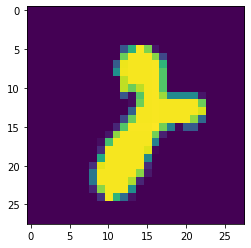

7


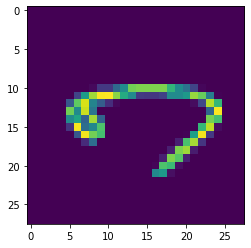

1


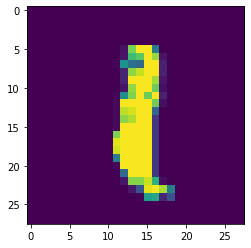

0


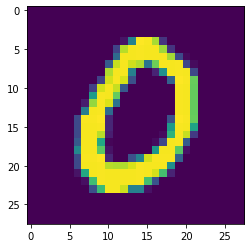

3


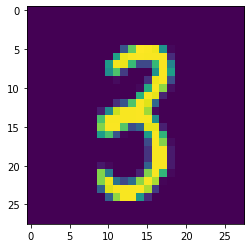

In [6]:
# Explore data
show5(train_loader_base)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
# Define the class of the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.2)
        self.log_softmax = F.log_softmax

    def forward(self, x):        
        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.log_softmax(self.fc5(x), dim=1)       
        
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Send the model to the device (CPU or GPU)
model = Net().to(device)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
        train_loss += loss.item()
        
    print(f'Len train loader: {len(train_loader)}')
    print(f'Len train loader dataset: {len(train_loader.dataset)}')
    avg_train_loss = train_loss/len(train_loader.dataset)
    
    return avg_train_loss

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
#             test_loss += F.nll_loss(output, target, reduction='sum').item()
            loss = criterion(output, target)
            test_loss += loss.item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Len test loader: {len(test_loader)}')
    print(f'Len test loader dataset: {len(test_loader.dataset)}')
    avg_test_loss = test_loss/len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, correct, len(test_loader.dataset),
        100. * test_accuracy))
    
    
    return avg_test_loss, test_accuracy

In [11]:
n_epochs = 5

# Create list to store loss
train_loss_history = list()
val_loss_history = list()
val_accuracy_history = list()

# Train the model
for epoch in range(1, n_epochs + 1):
    epoch_train_loss = train(model, device, train_loader, optimizer, epoch, 100)
    epoch_val_loss, epoch_val_accuracy = test(model, device, val_loader)
    
    train_loss_history.append(epoch_train_loss)
    val_loss_history.append(epoch_val_loss)
    val_accuracy_history.append(epoch_val_accuracy)
    
print(f'Model validation accuracy: {100*val_accuracy_history[-1]:.2f}%')    

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.296238
Train Epoch: 1 [2800/50000 (6%)]	Loss: 1.932273
Train Epoch: 1 [5600/50000 (11%)]	Loss: 0.669956
Train Epoch: 1 [8400/50000 (17%)]	Loss: 1.153392
Train Epoch: 1 [11200/50000 (22%)]	Loss: 0.496724
Train Epoch: 1 [14000/50000 (28%)]	Loss: 0.335865
Train Epoch: 1 [16800/50000 (34%)]	Loss: 0.585964
Train Epoch: 1 [19600/50000 (39%)]	Loss: 0.820317
Train Epoch: 1 [22400/50000 (45%)]	Loss: 0.285089
Train Epoch: 1 [25200/50000 (50%)]	Loss: 0.110080
Train Epoch: 1 [28000/50000 (56%)]	Loss: 0.116038
Train Epoch: 1 [30800/50000 (62%)]	Loss: 0.284235
Train Epoch: 1 [33600/50000 (67%)]	Loss: 0.393778
Train Epoch: 1 [36400/50000 (73%)]	Loss: 0.092877
Train Epoch: 1 [39200/50000 (78%)]	Loss: 0.543001
Train Epoch: 1 [42000/50000 (84%)]	Loss: 0.268203
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.163627
Train Epoch: 1 [47600/50000 (95%)]	Loss: 0.110198
Len train loader: 1786
Len train loader dataset: 50000
Len test loader: 358
Len test loader dataset: 10000

T

Plot the training loss (and validation loss/accuracy, if recorded).

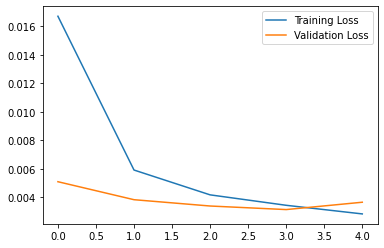

In [12]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
# Test the model
test_loss, test_accuracy = test(model, device, test_loader)
            
print(f'Model test accuracy: {100*test_accuracy:.2f}%') 

Len test loader: 358
Len test loader dataset: 10000

Test set: Average loss: 0.0035, Accuracy: 9716/10000 (97%)

Model test accuracy: 97.16%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
# Define the class of the neural network
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 probbability
        self.dropout = nn.Dropout(p=0.25)
        self.log_softmax = F.log_softmax

    def forward(self, x):        
        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.log_softmax(self.fc5(x), dim=1)       
        
        return x

In [18]:
n_epochs = 10

model2 = Net2().to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.90)

# Create list to store loss
train_loss_history2 = list()
val_loss_history2 = list()
val_accuracy_history2 = list()

# Train the model
for epoch in range(1, n_epochs + 1):
    epoch_train_loss2 = train(model2, device, train_loader, optimizer2, epoch, 100)
    epoch_val_loss2, epoch_val_accuracy2 = test(model2, device, val_loader)
    
    train_loss_history2.append(epoch_train_loss2)
    val_loss_history2.append(epoch_val_loss2)
    val_accuracy_history2.append(epoch_val_accuracy2)    

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302156
Train Epoch: 1 [2800/50000 (6%)]	Loss: 2.311321
Train Epoch: 1 [5600/50000 (11%)]	Loss: 2.298887
Train Epoch: 1 [8400/50000 (17%)]	Loss: 2.297371
Train Epoch: 1 [11200/50000 (22%)]	Loss: 2.278032
Train Epoch: 1 [14000/50000 (28%)]	Loss: 2.297268
Train Epoch: 1 [16800/50000 (34%)]	Loss: 2.247771
Train Epoch: 1 [19600/50000 (39%)]	Loss: 2.094756
Train Epoch: 1 [22400/50000 (45%)]	Loss: 2.075878
Train Epoch: 1 [25200/50000 (50%)]	Loss: 1.817349
Train Epoch: 1 [28000/50000 (56%)]	Loss: 1.164982
Train Epoch: 1 [30800/50000 (62%)]	Loss: 1.344666
Train Epoch: 1 [33600/50000 (67%)]	Loss: 1.033833
Train Epoch: 1 [36400/50000 (73%)]	Loss: 1.139241
Train Epoch: 1 [39200/50000 (78%)]	Loss: 0.994912
Train Epoch: 1 [42000/50000 (84%)]	Loss: 0.780493
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.199083
Train Epoch: 1 [47600/50000 (95%)]	Loss: 0.513964
Len train loader: 1786
Len train loader dataset: 50000
Len test loader: 358
Len test loader dataset: 10000

T

Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.236803
Train Epoch: 8 [47600/50000 (95%)]	Loss: 0.140172
Len train loader: 1786
Len train loader dataset: 50000
Len test loader: 358
Len test loader dataset: 10000

Test set: Average loss: 0.0034, Accuracy: 9736/10000 (97%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.031401
Train Epoch: 9 [2800/50000 (6%)]	Loss: 0.099754
Train Epoch: 9 [5600/50000 (11%)]	Loss: 0.077241
Train Epoch: 9 [8400/50000 (17%)]	Loss: 0.017211
Train Epoch: 9 [11200/50000 (22%)]	Loss: 0.056308
Train Epoch: 9 [14000/50000 (28%)]	Loss: 0.039029
Train Epoch: 9 [16800/50000 (34%)]	Loss: 0.496842
Train Epoch: 9 [19600/50000 (39%)]	Loss: 0.146190
Train Epoch: 9 [22400/50000 (45%)]	Loss: 0.055169
Train Epoch: 9 [25200/50000 (50%)]	Loss: 0.044832
Train Epoch: 9 [28000/50000 (56%)]	Loss: 0.051533
Train Epoch: 9 [30800/50000 (62%)]	Loss: 0.251771
Train Epoch: 9 [33600/50000 (67%)]	Loss: 0.676488
Train Epoch: 9 [36400/50000 (73%)]	Loss: 0.048365
Train Epoch: 9 [39200/50000 (78%)]	Loss: 

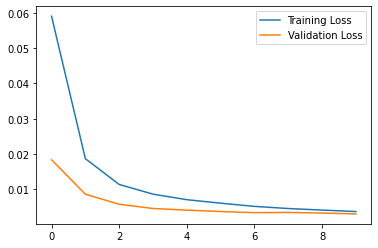

Model validation accuracy: 97.64%


In [19]:
plt.plot(train_loss_history2, label="Training Loss")
plt.plot(val_loss_history2, label="Validation Loss")
plt.legend()
plt.show()

print(f'Model validation accuracy: {100*val_accuracy_history2[-1]:.2f}%')

In [20]:
# Test the model    
test_loss2, test_accuracy2 = test(model2, device, test_loader)
        
print(f'Model test accuracy: {100*test_accuracy2:.2f}%')    

Len test loader: 358
Len test loader dataset: 10000

Test set: Average loss: 0.0031, Accuracy: 9749/10000 (97%)

Model test accuracy: 97.49%


## Saving your model
Using `torch.save`, save your model for future loading.

In [21]:
torch.save(model2.state_dict(), "mnist_model.pth")